In [1]:
y_drugs = {
    0: "risperidone",
    1: "clozapine",
    2: "olanzapine",
    3: "paliperidone",
    4: "chlorpromazine",
    5: "haloperidol",
    6: "asenapine",
    7: "perphenazine",
    8: "ziprasidone",
    9: "quetiapine",
    10: "aripiprazole",
    11: "lurasidone",
    12: "iloperidone"
}

In [2]:
import numpy as np

In [3]:
def one_hot_encode(y, n):
    return np.eye(n)[y]

In [4]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))

In [5]:
import random

In [6]:
random.seed(1234)

In [7]:
def generate_random_patient():
    return np.asarray([random.randrange(1, 4), random.randrange(1, 4), 0, 0, random.randrange(-6, 6), random.randrange(-6, 6), random.randrange(-6, 6), random.randrange(0, 10), random.randrange(0, 10), random.randrange(0, 240)])

In [8]:
def reward(prev_state, curr_state, prev_drug, curr_drug):
    prev_state = prev_state.T
    curr_state = curr_state.T
    return ((prev_state[0] - curr_state[0]) + (prev_state[1] - curr_state[1])) - (0.5 * (curr_state[2] - curr_state[2]) + 2 * (curr_state[3] - prev_state[3]) + 2 if prev_drug != curr_drug else 0)

In [9]:
def gradient(lr, reward, pred_reward, init_state, final_state, lbd, action, theta, n):
    reward_diff = (reward - pred_reward)
    dr_dt = n @ init_state.T * np.append(one_hot_encode(curr_drug, len(y_drugs)), 1) - lbd * n @ final_state.T * np.append(one_hot_encode(curr_drug, len(y_drugs)), 1)
    dp_dt = np.expand_dims(action, axis=1) - softmax((theta @ n) @ init_state.T)
    return ((lr ** 2) * reward_diff * dr_dt.T) - (lr * (reward_diff ** 2) * dp_dt)

In [10]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [11]:
def prob_episode(init_state, action, theta, n):
    return one_hot_encode(action, len(y_drugs) + 1) @ softmax((theta @ n) @ init_state.T)

In [12]:
def change_environment(init_state, drug):
    init_state = init_state.T
    drug_effects = {
        "risperidone": {"p": 0.61, "n": 0.37, "met_s": 0.25, "eps_td": 0.25},
        "clozapine": {"p": 0.64, "n": 0.62, "met_s": 0.6, "eps_td": 0.1},
        "olanzapine": {"p": 0.53, "n": 0.45, "met_s": 0.6, "eps_td": 0.25},
        "paliperidone": {"p": 0.53, "n": 0.37, "met_s": 0.25, "eps_td": 0.25},
        "chlorpromazine": {"p": 0.57, "n": 0.35, "met_s": 0.25, "eps_td": 0.4},
        "haloperidol": {"p": 0.49, "n": 0.29, "met_s": 0.1, "eps_td": 0.6},
        "asenapine": {"p": 0.47, "n": 0.42, "met_s": 0.1, "eps_td": 0.25},
        "perphenazine": {"p": 0.45, "n": 0.42, "met_s": 0.1, "eps_td": 0.6},
        "ziprasidone": {"p": 0.43, "n": 0.33, "met_s": 0.1, "eps_td": 0.25},
        "quetiapine": {"p": 0.4, "n": 0.31, "met_s": 0.25, "eps_td": 0.1},
        "aripiprazole": {"p": 0.38, "n": 0.33, "met_s": 0.1, "eps_td": 0.1},
        "lurasidone": {"p": 0.33, "n": 0.29, "met_s": 0.05, "eps_td": 0.1},
        "iloperidone": {"p": 0.3, "n": 0.22, "met_s": 0.25, "eps_td": 0.05}
    }
    delta_positive = init_state[4] * drug_effects[drug]["p"] * (init_state[7] / 10) * sigmoid((init_state[8] / 10) - (init_state[9] / 240))
    delta_negative = init_state[4] * drug_effects[drug]["n"] * (init_state[7] / 10) * sigmoid((init_state[8] / 10) - (init_state[9] / 240))
    delta_met_s = init_state[5] * drug_effects[drug]["met_s"] * (init_state[7] / 10)
    delta_eps_td = init_state[6] * drug_effects[drug]["eps_td"] * (init_state[7] / 10)
    delta_compliance = sigmoid(init_state[9] - 120)
    delta_stress = -(sigmoid(init_state[9] - 120))
    arr = [init_state[0] + delta_positive, init_state[1] + delta_negative, init_state[2] + delta_met_s, init_state[3] + delta_eps_td, init_state[4], init_state[5], init_state[6], init_state[7] + delta_compliance, init_state[8] + delta_stress, init_state[9]]
    return np.asarray(arr)

In [13]:
theta = np.random.rand(len(y_drugs) + 1, 1)
n = np.ones((1, len(generate_random_patient())))
lbd = 0.5
lr = 0.0001

In [14]:
loss_hist = []
epoch_hist = []
for i in range(2500):
    epoch_hist.append(i)
    init_state = generate_random_patient()
    init_state = np.expand_dims(init_state, axis=0)
    final_state = init_state
    prev_drug = -1
    curr_drug = -1
    loss = 0
    for j in range(15):
        #Forward pass
        curr_drug = np.argmax(softmax((theta @ n) @ init_state.T)[:-1])
        #Determine final state
        final_state = change_environment(init_state, y_drugs[curr_drug]).T
        #Determine reward
        if prev_drug == -1:
            prev_drug = curr_drug
        r = reward(init_state, final_state, prev_drug, curr_drug)
        print("Epoch: ", i, " Episode: ", j, " Reward: ", r)
        #Determine predicted reward
        r_hat = n @ ((theta @ init_state).T @ np.append(one_hot_encode(curr_drug, len(y_drugs)), 1)) - lbd * n @ ((theta @ final_state).T @ np.append(one_hot_encode(curr_drug, len(y_drugs)), 1))
        #Loss
        loss += (r - r_hat) ** 2 * prob_episode(init_state, curr_drug, theta, n)
        #Gradient descent
        theta += gradient(lr, r, r_hat, init_state, final_state, lbd, one_hot_encode(curr_drug, len(y_drugs) + 1), theta, n)
        #New init state is previous final state
        init_state = final_state
    print("Epoch: ", i, " Loss: ", loss)
    loss_hist.append(loss)

Epoch:  0  Episode:  0  Reward:  [2.25167316]
Epoch:  0  Episode:  1  Reward:  [2.57653641]
Epoch:  0  Episode:  2  Reward:  [2.866398]
Epoch:  0  Episode:  3  Reward:  [3.12116578]
Epoch:  0  Episode:  4  Reward:  [3.34106612]
Epoch:  0  Episode:  5  Reward:  [3.5266443]
Epoch:  0  Episode:  6  Reward:  [3.67875629]
Epoch:  0  Episode:  7  Reward:  [3.79855215]
Epoch:  0  Episode:  8  Reward:  [3.88745166]
Epoch:  0  Episode:  9  Reward:  [3.94711334]
Epoch:  0  Episode:  10  Reward:  [3.97939814]
Epoch:  0  Episode:  11  Reward:  [3.98632939]
Epoch:  0  Episode:  12  Reward:  [3.97005069]
Epoch:  0  Episode:  13  Reward:  [12.950674]
Epoch:  0  Episode:  14  Reward:  [3.87678495]
Epoch:  0  Loss:  [90485.11771697]
Epoch:  1  Episode:  0  Reward:  [0.11535881]
Epoch:  1  Episode:  1  Reward:  [-1.49054864]
Epoch:  1  Episode:  2  Reward:  [-1.26955203]
Epoch:  1  Episode:  3  Reward:  [-1.06946279]
Epoch:  1  Episode:  4  Reward:  [-0.88896233]
Epoch:  1  Episode:  5  Reward:  [-0.726

In [15]:
import matplotlib.pyplot as plt

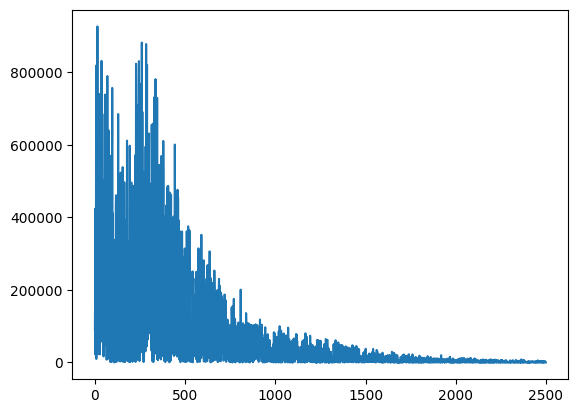

In [16]:
plt.plot(epoch_hist, loss_hist)
plt.show()